Calculating the Normalized Difference Aquatic Vegetation Index (NDAVI) in South Florida using Landsat 8 and 9 data. NDAVI is an index used to analyze aquatic vegetation, such as seagrass beds. This map would be better with the Normalized Difference Water Index applied to it. 

In [3]:
import pystac
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import planetary_computer
import numpy as np
import matplotlib.pyplot as plt
import odc.stac
import xarray as xr
from collections import defaultdict
import pandas as pd
import tifffile
import rasterio
from rasterio.transform import from_bounds

In [2]:
pip install odc.stac

Note: you may need to restart the kernel to use updated packages.


Returned 10 Items
Selected 10 items across months
Processing LC08_L2SP_016042_20240121_02_T1 from 2024-01-21 with 2.78% cloud cover
Processing LC09_L2SP_017042_20240120_02_T2 from 2024-01-20 with 3.82% cloud cover
Processing LC08_L2SP_014043_20240123_02_T1 from 2024-01-23 with 4.29% cloud cover
Processing LC09_L2SP_017043_20240120_02_T2 from 2024-01-20 with 5.55% cloud cover
Processing LC08_L2SP_017043_20240128_02_T2 from 2024-01-28 with 6.27% cloud cover
Processing LC08_L2SP_017042_20240128_02_T2 from 2024-01-28 with 7.76% cloud cover
Processing LC08_L2SP_014043_20240107_02_T1 from 2024-01-07 with 9.04% cloud cover
Processing LC08_L2SP_015042_20240130_02_T1 from 2024-01-30 with 11.93% cloud cover
Processing LC08_L2SP_015043_20240130_02_T1 from 2024-01-30 with 13.32% cloud cover
Processing LC08_L2SP_016043_20240121_02_T1 from 2024-01-21 with 14.3% cloud cover


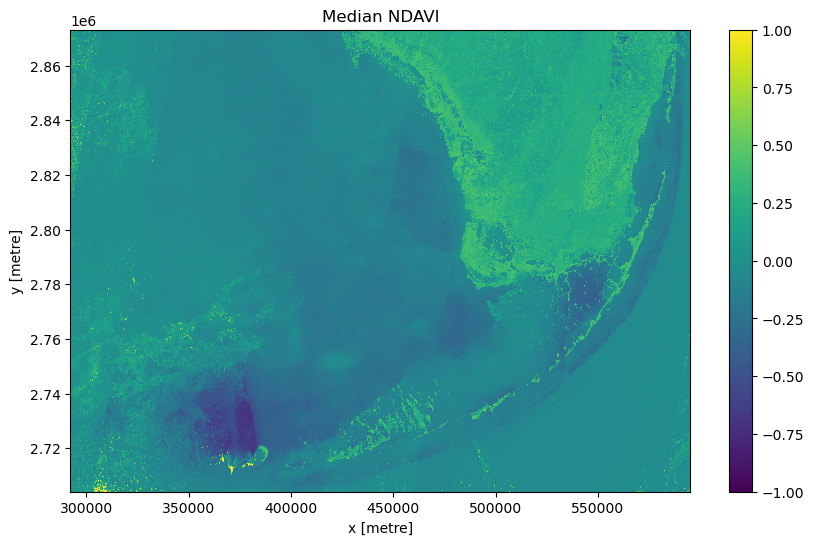


Summary of valid images per month:
Month       | Count of valid images
-----------------------------------
2024-01 | 10


In [2]:
#Choose the STAC API based on the catalog information needed
stac_api = "https://planetarycomputer.microsoft.com/api/stac/v1"
 
#Open the STAC API
client = Client.open(stac_api)
 
#Time and location information
bbox_of_interest = [-83.049747,24.447482,-80.062152,25.962077] #csv format from (https://boundingbox.klokantech.com/) everglades
time_of_interest = "2024-01-01/2024-01-31"  #ymd
 
#Search the STAC catalog for Landsat 8/9 images that meet our criteria
search = client.search(
    collections=["landsat-c2-l2"],  #Landsat Collection 2, Level 2
    bbox=bbox_of_interest,
    datetime=time_of_interest,
    query={
        "eo:cloud_cover": {"lt": 15},  #Filter for images with less than 30% cloud cover
        "platform": {"in": ["landsat-8", "landsat-9"]},  #Landsat 8 and 9 platforms
    },
)
 
#Return the number of items found
items = search.item_collection()
print(f"Returned {len(items)} Items")
 
#Group images by month
items_by_month = defaultdict(list)
for item in items:
    month_str = item.datetime.strftime("%Y-%m")
    items_by_month[month_str].append(item)
 
#Track the count of non-skipped images per month
valid_images_count = defaultdict(int)
valid_xarrays = []  #List to store xarray DataArrays for valid images
 
#Select at least x images per month with the least cloud cover
selected_items = []
for month, items_in_month in items_by_month.items():
    #Sort by cloud cover and select the top x (or less if fewer than x are available)
   sorted_items = sorted(items_in_month, key=lambda item: eo.ext(item).cloud_cover)
   selected_items.extend(sorted_items[:100])  #Select the first x items

print(f"Selected {len(selected_items)} items across months")
 
#Process each selected item
for selected_item in selected_items:
    month_str = selected_item.datetime.strftime("%Y-%m")
   
    print(
        f"Processing {selected_item.id} from {selected_item.datetime.date()} "
        + f"with {selected_item.properties['eo:cloud_cover']}% cloud cover"
    )

    
    #Select bands to analyze and sign the file so it can be accessed
    bands_of_interest = ["nir08","red","green","blue","qa_pixel","lwir11"] #https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/
    signed_item = planetary_computer.sign(selected_item)
 
    #Load the data
    data = odc.stac.stac_load([signed_item], bands=bands_of_interest, bbox=bbox_of_interest).isel(time=0)

    #NDAVI
    blue = data["blue"].astype("float")
    nir = data["nir08"].astype("float")
    ndvi = (nir - blue) / (nir + blue)

    #Increment the count for valid images in this month
    valid_images_count[month_str] += 1

    #Store the valid xarray
    valid_xarrays.append(ndvi)

#Combine all valid xarrays and calculate the median LST
if valid_xarrays:
    combined_data = xr.concat(valid_xarrays, dim="time")  #Combine along a new "time" dimension
    median_ndavi = combined_data.median(dim="time")  #Calculate the median along the "time" dimension
 
    #Add in a CRS (WGS 84)
    crs = "EPSG:4326"
    bbox = bbox_of_interest
    transform = from_bounds(bbox[0], bbox[1], bbox[2], bbox[3],
                            median_ndavi.shape[1],
                            median_ndavi.shape[0])
 
    #Save the temperature data to a GeoTIFF with CRS and transform
    with rasterio.open(
        "median_ndavi.tif",
        "w",
        driver="GTiff",
        height=median_ndavi.shape[0],
        width=median_ndavi.shape[1],
        count=1,
        dtype=median_ndavi.values.dtype,
        crs=crs,
        transform=transform,
    ) as dst:
        dst.write(median_ndavi.values, 1)
 
    #Plot the composite median raster image
    plt.figure(figsize=(10, 6))
    median_ndavi.plot(cmap="viridis")
    plt.title("Median NDAVI")
    plt.show()
 
#Print the final table with the count of valid images per month
print("\nSummary of valid images per month:")
print("Month       | Count of valid images")
print("-----------------------------------")
for month, count in valid_images_count.items():
    print(f"{month} | {count}")